Importing Required Libraries

In [2]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn nltk scikit-learn wordcloud textblob tqdm 
!pip install tensorflow-cpu  

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import gc 
from tqdm import tqdm

In [4]:
# For preprocessing
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [5]:
# For ML models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier

In [6]:
# For deep learning (with memory optimizations)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D

In [7]:
# Configure TensorFlow to use memory growth option
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Set memory limit for TensorFlow
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])  # Limit to 1GB

IndexError: list index out of range

In [8]:
# Memory optimization function
def optimize_memory():
    gc.collect()
    tf.keras.backend.clear_session()


In [9]:
# Load dataset
train = pd.read_csv('data/train.csv', index_col='id')
print(f"Dataset shape: {train.shape}")

# Fill missing values
train = train.fillna(' ')

Dataset shape: (20800, 4)


In [10]:
# Create feature by combining text fields
train['total'] = train['title'] + ' ' + train['author'] + train['text']

In [11]:
# Drop unnecessary columns to save memory
df = train.drop(['title', 'author', 'total'], axis=1)
del train  # Free memory
optimize_memory()

In [12]:
# Text preprocessing function
def wordopt(text):
    text = str(text).lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("\\W", " ", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

<>:4: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\w'
C:\Users\nyash\AppData\Local\Temp\ipykernel_17064\2332277985.py:4: SyntaxWarning: invalid escape sequence '\['
  text = re.sub("\[.*?\]", "", text)
C:\Users\nyash\AppData\Local\Temp\ipykernel_17064\2332277985.py:6: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub("https?://\S+|www\.\S+", "", text)
C:\Users\nyash\AppData\Local\Temp\ipykernel_17064\2332277985.py:10: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [ ]:
# Enhanced preprocessing with NLP features
def enhanced_preprocessing(text):
    # Basic preprocessing
    text = wordopt(text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

In [14]:
# Apply preprocessing (in smaller chunks to save memory)
chunk_size = 5000
chunks = [df['text'][i:i+chunk_size] for i in range(0, len(df), chunk_size)]
processed_chunks = []

for chunk in tqdm(chunks, desc="Processing text"):
    processed_chunk = chunk.apply(enhanced_preprocessing)
    processed_chunks.append(processed_chunk)
    
df['text'] = pd.concat(processed_chunks)
optimize_memory()

Processing text: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.45s/it]


In [15]:
# Split features and target
X = df['text']
y = df['label']

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
# Create TF-IDF features with memory optimization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=50000)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [17]:
# Memory-efficient implementation for traditional ML models
def train_evaluate_model(model, name):
    print(f"\nTraining {name}...")
    model.fit(tfidf_train, y_train)
    
    # Predict
    pred = model.predict(tfidf_test)
    
    # Evaluate
    cm = confusion_matrix(y_test, pred)
    score = accuracy_score(y_test, pred)
    
    print(f"{name} Confusion Matrix:\n{cm}")
    print(f"{name} Accuracy: {score:.3f}")
    
    # Memory cleanup
    optimize_memory()
    
    return model, cm, score

In [19]:
# Train traditional ML models
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(random_state=0, max_iter=1000),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=1000, n_jobs=-1),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(random_state=0, max_iter=1000)
}

results = []
confusion_matrices = {}

In [20]:
for name, model in models.items():
    trained_model, cm, score = train_evaluate_model(model, name)
    models[name] = trained_model
    confusion_matrices[name] = cm
    results.append([name, score])


Training MultinomialNB...
MultinomialNB Confusion Matrix:
[[2565   77]
 [ 455 2103]]
MultinomialNB Accuracy: 0.898

Training LogisticRegression...
LogisticRegression Confusion Matrix:
[[2460  182]
 [ 145 2413]]
LogisticRegression Accuracy: 0.937

Training KNeighborsClassifier...
KNeighborsClassifier Confusion Matrix:
[[2334  308]
 [ 398 2160]]
KNeighborsClassifier Accuracy: 0.864

Training PassiveAggressiveClassifier...
PassiveAggressiveClassifier Confusion Matrix:
[[2526  116]
 [ 117 2441]]
PassiveAggressiveClassifier Accuracy: 0.955


In [21]:
# Implement LSTM with memory optimization
# For memory reasons, we'll use a smaller vocabulary and sequence length
def create_deep_learning_features():
    print("\nCreating deep learning features...")
    
    # Initialize tokenizer with a reasonable vocabulary size
    max_words = 10000
    max_seq_length = 200
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    
    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    # Pad sequences to uniform length
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)
    
    return X_train_pad, X_test_pad, tokenizer, max_words, max_seq_length


In [22]:
# Create features for deep learning
X_train_pad, X_test_pad, tokenizer, max_words, max_seq_length = create_deep_learning_features()
optimize_memory()


Creating deep learning features...


In [ ]:
# Define BiLSTM model with memory optimization
def create_bilstm_model(max_words, max_seq_length):
    print("Creating BiLSTM model...")
    model = Sequential()
    model.add(Embedding(max_words, 64, input_length=max_seq_length))
    model.add(SpatialDropout1D(0.2))  # Helps with regularization and memory
    model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [23]:
# Train BiLSTM with small batches to conserve memory
bilstm_model = create_bilstm_model(max_words, max_seq_length)
print(bilstm_model.summary())

# Train with small batch size and early stopping to save memory
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,  # Limit epochs for memory
    batch_size=32,  # Small batch size for memory
    callbacks=[early_stopping],
    verbose=1
)


NameError: name 'create_bilstm_model' is not defined

In [ ]:
# Evaluate BiLSTM
bilstm_pred = bilstm_model.predict(X_test_pad, batch_size=32)
bilstm_pred_binary = (bilstm_pred > 0.5).astype(int)
bilstm_cm = confusion_matrix(y_test, bilstm_pred_binary)
bilstm_score = accuracy_score(y_test, bilstm_pred_binary)

print("\nBiLSTM Confusion Matrix:")
print(bilstm_cm)
print(f"BiLSTM Accuracy: {bilstm_score:.3f}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step

BiLSTM Confusion Matrix:
[[2433  209]
 [ 230 2328]]
BiLSTM Accuracy: 0.916


In [ ]:
# Add BiLSTM results
results.append(["BiLSTM", bilstm_score])
confusion_matrices["BiLSTM"] = bilstm_cm
optimize_memory()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Create and train ensemble model for improved performance
def create_ensemble():
    print("\nCreating ensemble model...")
    
    # Calibrate PassiveAggressiveClassifier to enable probability prediction
    print("Calibrating PassiveAggressiveClassifier...")
    calibrated_pa = CalibratedClassifierCV(
    estimator=models["PassiveAggressiveClassifier"], 
    cv=3,
    method='sigmoid'
)

    calibrated_pa.fit(tfidf_train, y_train)
    
    # Create weighted ensemble with models that support predict_proba
    estimators = [
        ('pa', calibrated_pa),
        ('lr', models["LogisticRegression"])
    ]
    
    # Now ensemble will work with soft voting
    ensemble = VotingClassifier(estimators=estimators, voting='soft')
    ensemble.fit(tfidf_train, y_train)
    
    # Make predictions
    pred = ensemble.predict(tfidf_test)
    cm = confusion_matrix(y_test, pred)
    score = accuracy_score(y_test, pred)
    
    print("Ensemble Confusion Matrix:")
    print(cm)
    print(f"Ensemble Accuracy: {score:.3f}")
    
    return ensemble, cm, score

# Create ensemble
ensemble_model, ensemble_cm, ensemble_score = create_ensemble()
results.append(["Ensemble", ensemble_score])
confusion_matrices["Ensemble"] = ensemble_cm



Creating ensemble model...
Calibrating PassiveAggressiveClassifier...
Ensemble Confusion Matrix:
[[2520  122]
 [ 130 2428]]
Ensemble Accuracy: 0.952


In [ ]:
# First define the function
def hybrid_predict(text_sample):
    # Preprocess
    processed_text = enhanced_preprocessing(text_sample)
    
    # Get TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([processed_text])
    
    # Get traditional ML prediction
    pa_pred = models["PassiveAggressiveClassifier"].predict(tfidf_features)[0]
    ensemble_pred = ensemble_model.predict(tfidf_features)[0]
    
    # Get deep learning prediction
    dl_sequence = tokenizer.texts_to_sequences([processed_text])
    dl_padded = pad_sequences(dl_sequence, maxlen=max_seq_length)
    bilstm_prob = bilstm_model.predict(dl_padded)[0][0]
    bilstm_pred = 1 if bilstm_prob > 0.5 else 0
    
    # Weighted combination for final prediction
    final_prediction = (0.4 * pa_pred + 0.3 * ensemble_pred + 0.3 * bilstm_pred) > 0.5
    
    return int(final_prediction), {
        'pa_pred': pa_pred,
        'ensemble_pred': ensemble_pred,
        'bilstm_pred': bilstm_pred,
        'bilstm_confidence': float(bilstm_prob),
        'final_prediction': int(final_prediction)
    }

# Then call it
print("\nCreating hybrid predictions...")
test_samples = X_test.iloc[:5].values
for i, sample in enumerate(test_samples):
    _, prediction_details = hybrid_predict(sample)
    print(f"\nSample {i+1} prediction details:")
    for k, v in prediction_details.items():
        print(f"{k}: {v}")



Creating hybrid predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

Sample 1 prediction details:
pa_pred: 1
ensemble_pred: 1
bilstm_pred: 1
bilstm_confidence: 0.9875160455703735
final_prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Sample 2 prediction details:
pa_pred: 1
ensemble_pred: 1
bilstm_pred: 1
bilstm_confidence: 0.9730890393257141
final_prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Sample 3 prediction details:
pa_pred: 0
ensemble_pred: 0
bilstm_pred: 0
bilstm_confidence: 0.017523186281323433
final_prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Sample 4 prediction details:
pa_pred: 0
ensemble_pred: 0
bilstm_pred: 0
bilstm_confidence: 0.0025430689565837383
final_prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

Sample 5 prediction details:
pa_pred: 1
ensemble_pred: 1
bilstm_pred: 1
bilstm_confidence: 0.9522561430931091
final_prediction: 1


In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Classifier", "Accuracy"])
print("\nModel Accuracy Comparison:")
print(results_df)


Model Accuracy Comparison:
                    Classifier  Accuracy
0                MultinomialNB  0.897692
1           LogisticRegression  0.937115
2         KNeighborsClassifier  0.864231
3  PassiveAggressiveClassifier  0.955192
4                       BiLSTM  0.915577
5                     Ensemble  0.951538


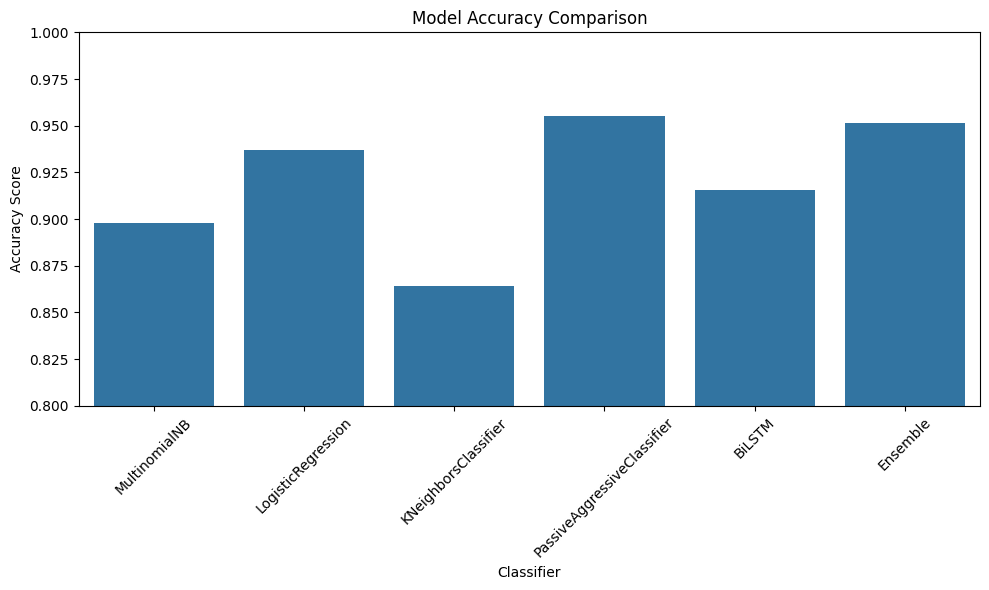

In [ ]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Classifier", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.ylim(0.8, 1.0)
plt.xlabel("Classifier")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

In [ ]:
# Plot confusion matrices
def plot_confusion_matrices():
    fig, axes = plt.subplots(2, 3, figsize=(8, 5))
    axes = axes.flatten()
    
    models_to_plot = list(confusion_matrices.keys())
    
    for i, model_name in enumerate(models_to_plot[:6]):  # Plot up to 6 models
        if i < len(axes):
            sns.heatmap(confusion_matrices[model_name], annot=True, fmt="d", cmap="Blues", ax=axes[i])
            axes[i].set_title(model_name)
            axes[i].set_xlabel("Predicted Labels")
            axes[i].set_ylabel("True Labels")
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

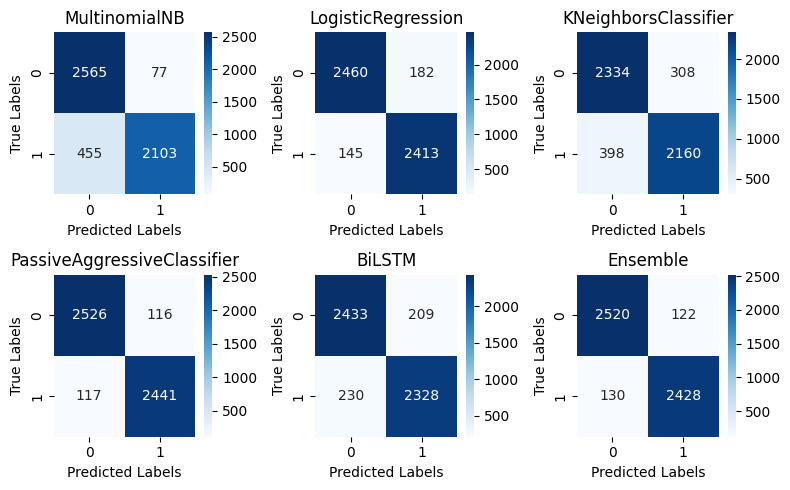

In [ ]:
# Plot confusion matrices
plot_confusion_matrices()

In [ ]:
# Save models
def save_models():
    print("\nSaving models...")
    os.makedirs("C:/Users/nyash/FAKE_NEWS/Copy/pickles", exist_ok=True)
    
    # Save traditional ML models
    pickle.dump(models["PassiveAggressiveClassifier"], open('C:/Users/nyash/FAKE_NEWS/Copy/pickles/PA.pickle', 'wb'))
    pickle.dump(tfidf_vectorizer, open('C:/Users/nyash/FAKE_NEWS/Copy/pickles/tfidf_vectorizer.pickle', 'wb'))
    
    # Save ensemble model
    pickle.dump(ensemble_model, open('C:/Users/nyash/FAKE_NEWS/Copy/pickles/ensemble.pickle', 'wb'))
    
    # Save BiLSTM model with proper .keras extension
    bilstm_model.save('C:/Users/nyash/FAKE_NEWS/Copy/pickles/bilstm_model.keras')
    
    # Save tokenizer
    pickle.dump(tokenizer, open('C:/Users/nyash/FAKE_NEWS/Copy/pickles/tokenizer.pickle', 'wb'))
    
    print("Models saved successfully!")

# Execute saving
import os
save_models()

# Final memory cleanup
optimize_memory()
print("\nAll processes completed successfully!")



Saving models...
Models saved successfully!

All processes completed successfully!
